# 4.0 Home Run Rates
Attempting to predict home run rates based on batted ball type and direction

## Libraries

In [1]:
import os
import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.regressor import ResidualsPlot, PredictionError

## Data

In [2]:
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [3]:
params = {
    'game_type': 'R'
}

In [4]:
SQL = \
"""
SELECT
  t_bb.game_year AS game_year,
  t_players.mlb_id AS mlb_id,
  t_players.mlb_name AS mlb_name,
  t_players.fg_id AS fangraphs_id,
  t_bb.bb_events AS bb_events,
  t_bb.home_runs AS home_runs,
  ROUND(t_bb.home_runs / t_bb.bb_events, 3) AS hr_rate,
  (CASE WHEN t_bb.fly_events > 0 OR t_bb.line_events > 0
      THEN ROUND(t_bb.home_runs / (t_bb.fly_events + t_bb.line_events), 3)
    ELSE 0 END) AS hr_air_rate,
  (CASE WHEN t_bb.fly_events > 0 THEN ROUND(t_bb.fly_home_runs / t_bb.fly_events, 3)
    ELSE 0 END) AS fly_hr_rate,
  (CASE WHEN t_bb.line_events > 0 THEN ROUND(t_bb.line_home_runs / t_bb.line_events, 3)
    ELSE 0 END) AS line_hr_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_oppo_rate,
  t_bb.fly_events AS fly_events,
  t_bb.line_events AS line_events,
  t_bb.ground_events AS ground_events,
  t_bb.pop_events AS pop_events,
  t_bb.fly_pull_events AS fly_pull_events,
  t_bb.fly_center_events AS fly_center_events,
  t_bb.fly_oppo_events AS fly_oppo_events,
  t_bb.line_pull_events AS line_pull_events,
  t_bb.line_center_events AS line_center_events,
  t_bb.line_oppo_events AS line_oppo_events,
  t_bb.ground_pull_events AS ground_pull_events,
  t_bb.ground_center_events AS ground_center_events,
  t_bb.ground_oppo_events AS ground_oppo_events,
  t_bb.pop_pull_events AS pop_pull_events,
  t_bb.pop_center_events AS pop_center_events,
  t_bb.pop_oppo_events AS pop_oppo_events,
  t_bb.fly_max_exit_velo AS fly_max_exit_velo,
  t_bb.fly_p75_exit_velo AS fly_p75_exit_velo,
  t_bb.fly_p90_exit_velo AS fly_p90_exit_velo,
  t_bb.fly_p95_exit_velo AS fly_p95_exit_velo,
  t_bb.fly_pull_max_exit_velo AS fly_pull_max_exit_velo,
  t_bb.fly_pull_p75_exit_velo AS fly_pull_p75_exit_velo,
  t_bb.fly_pull_p90_exit_velo AS fly_pull_p90_exit_velo,
  t_bb.fly_pull_p95_exit_velo AS fly_pull_p95_exit_velo,
  t_bb.fly_center_max_exit_velo AS fly_center_max_exit_velo,
  t_bb.fly_center_p75_exit_velo AS fly_center_p75_exit_velo,
  t_bb.fly_center_p90_exit_velo AS fly_center_p90_exit_velo,
  t_bb.fly_center_p95_exit_velo AS fly_center_p95_exit_velo,
  t_bb.fly_oppo_max_exit_velo AS fly_oppo_max_exit_velo,
  t_bb.fly_oppo_p75_exit_velo AS fly_oppo_p75_exit_velo,
  t_bb.fly_oppo_p90_exit_velo AS fly_oppo_p90_exit_velo,
  t_bb.fly_oppo_p95_exit_velo AS fly_oppo_p95_exit_velo,
  t_bb.line_max_exit_velo AS line_max_exit_velo,
  t_bb.line_p75_exit_velo AS line_p75_exit_velo,
  t_bb.line_p90_exit_velo AS line_p90_exit_velo,
  t_bb.line_p95_exit_velo AS line_p95_exit_velo,
  t_bb.line_pull_max_exit_velo AS line_pull_max_exit_velo,
  t_bb.line_pull_p75_exit_velo AS line_pull_p75_exit_velo,
  t_bb.line_pull_p90_exit_velo AS line_pull_p90_exit_velo,
  t_bb.line_pull_p95_exit_velo AS line_pull_p95_exit_velo,
  t_bb.line_center_max_exit_velo AS line_center_max_exit_velo,
  t_bb.line_center_p75_exit_velo AS line_center_p75_exit_velo,
  t_bb.line_center_p90_exit_velo AS line_center_p90_exit_velo,
  t_bb.line_center_p95_exit_velo AS line_center_p95_exit_velo,
  t_bb.line_oppo_max_exit_velo AS line_oppo_max_exit_velo,
  t_bb.line_oppo_p75_exit_velo AS line_oppo_p75_exit_velo,
  t_bb.line_oppo_p90_exit_velo AS line_oppo_p90_exit_velo,
  t_bb.line_oppo_p95_exit_velo AS line_oppo_p95_exit_velo,
  t_bb.ground_max_exit_velo AS ground_max_exit_velo,
  t_bb.ground_p75_exit_velo AS ground_p75_exit_velo,
  t_bb.ground_p90_exit_velo AS ground_p90_exit_velo,
  t_bb.ground_p95_exit_velo AS ground_p95_exit_velo,
  t_bb.ground_pull_max_exit_velo AS ground_pull_max_exit_velo,
  t_bb.ground_pull_p75_exit_velo AS ground_pull_p75_exit_velo,
  t_bb.ground_pull_p90_exit_velo AS ground_pull_p90_exit_velo,
  t_bb.ground_pull_p95_exit_velo AS ground_pull_p95_exit_velo,
  t_bb.ground_center_max_exit_velo AS ground_center_max_exit_velo,
  t_bb.ground_center_p75_exit_velo AS ground_center_p75_exit_velo,
  t_bb.ground_center_p90_exit_velo AS ground_center_p90_exit_velo,
  t_bb.ground_center_p95_exit_velo AS ground_center_p95_exit_velo,
  t_bb.ground_oppo_max_exit_velo AS ground_oppo_max_exit_velo,
  t_bb.ground_oppo_p75_exit_velo AS ground_oppo_p75_exit_velo,
  t_bb.ground_oppo_p90_exit_velo AS ground_oppo_p90_exit_velo,
  t_bb.ground_oppo_p95_exit_velo AS ground_oppo_p95_exit_velo
FROM
  (
    SELECT
      game_year,
      batter_id,
      COALESCE(SUM(bb_events), 0) AS bb_events,
      COALESCE(SUM(home_runs), 0) AS home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' THEN home_runs END), 0) AS fly_home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' THEN home_runs END), 0) AS line_home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' THEN bb_events END), 0) AS fly_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' THEN bb_events END), 0) AS line_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' THEN bb_events END), 0) AS ground_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' THEN bb_events END), 0) AS pop_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN bb_events END), 0) AS fly_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN bb_events END), 0) AS fly_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN bb_events END), 0) AS fly_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN bb_events END), 0) AS line_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN bb_events END), 0) AS line_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN bb_events END), 0) AS line_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN bb_events END), 0) AS ground_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN bb_events END), 0) AS ground_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN bb_events END), 0) AS ground_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'pull' THEN bb_events END), 0) AS pop_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'center' THEN bb_events END), 0) AS pop_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'oppo' THEN bb_events END), 0) AS pop_oppo_events,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN max_exit_velo END), 0) AS fly_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS fly_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS fly_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS fly_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS fly_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS fly_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS fly_oppo_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN max_exit_velo END), 0) AS line_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS line_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS line_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS line_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS line_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS line_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS line_oppo_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN max_exit_velo END), 0) AS ground_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN max_exit_velo END), 0) AS ground_pull_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_pull_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_pull_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_pull_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN max_exit_velo END), 0) AS ground_center_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_center_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_center_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_center_p95_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN max_exit_velo END), 0) AS ground_oppo_max_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(75)] END), 0) AS ground_oppo_p75_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(90)] END), 0) AS ground_oppo_p90_exit_velo,
      COALESCE(MAX(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN exit_velo_percentiles[OFFSET(95)] END), 0) AS ground_oppo_p95_exit_velo
    FROM
      (
        SELECT
          EXTRACT(YEAR FROM game_date) AS game_year,
          batter AS batter_id,
          bb_type AS bb_type,
          (CASE WHEN (spray_angle_est < -15 AND stand = 'R') OR (spray_angle_est > 15 AND stand = 'L') THEN 'pull'
                WHEN (spray_angle_est < -15 AND stand = 'L') OR (spray_angle_est > 15 AND stand = 'R') THEN 'oppo'
                WHEN spray_angle_est BETWEEN -15 AND 15 THEN 'center'
                ELSE 'no-angle'
          END) AS bb_direction,
          COUNT(*) AS bb_events,
          SUM(CASE WHEN events = 'home_run' THEN 1 END) AS home_runs,
          APPROX_QUANTILES(launch_speed, 100) AS exit_velo_percentiles,
          MAX(launch_speed) AS max_exit_velo
        FROM
          `ad-fantasy-baseball.core.statcast_extended`
        WHERE
          game_type = 'R'
            AND type = 'X'
            AND NOT (events = 'field_out' AND REGEXP_CONTAINS(des, r'(?i)foul\sterritory'))
        GROUP BY 1, 2, 3, 4
      )
    GROUP BY 1, 2
    HAVING bb_events > 0
  ) t_bb
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name,
      fg_id
    FROM
      `ad-fantasy-baseball.core.players`
    GROUP BY 1, 2, 3
  ) t_players
    ON (t_bb.batter_id = t_players.mlb_id)
"""

In [5]:
sql_base = SQL.format(**params)
df_base = read_gbq(query=sql_base, dialect='standard', project_id=PROJECT_ID, private_key=CREDENTIALS_PATH)

df_copy = df_base.copy()

Data Preparation
----------

In [6]:
EVENT_THRESHOLD = 100
HR_THRESHOLD = 5
HR_RATE_THRESHOLD = 0

In [7]:
# Filters
_min_events = df_base['bb_events'] > EVENT_THRESHOLD
_min_hr = df_base['home_runs'] > HR_THRESHOLD
_min_hr_rate = df_base['hr_rate'] > HR_RATE_THRESHOLD
_threshold = _min_events & _min_hr & _min_hr_rate

In [8]:
df_threshold = df_base[_threshold]

In [9]:
df_threshold.head()

,game_year,mlb_id,mlb_name,fangraphs_id,bb_events,home_runs,hr_rate,hr_air_rate,fly_hr_rate,line_hr_rate,...,ground_pull_p90_exit_velo,ground_pull_p95_exit_velo,ground_center_max_exit_velo,ground_center_p75_exit_velo,ground_center_p90_exit_velo,ground_center_p95_exit_velo,ground_oppo_max_exit_velo,ground_oppo_p75_exit_velo,ground_oppo_p90_exit_velo,ground_oppo_p95_exit_velo
1969,2015,547379,Roberto Perez,2900,124,7,0.056,0.137,0.176,0.118,...,93.1,96.8,110.6,96.1,102.5,109.5,110.8,104.3,105,110.8
2070,2015,285078,Josh Hamilton,1875,118,8,0.068,0.133,0.190,0.103,...,103.9,109.4,95.7,85.9,95.7,95.7,101,88.1,101,101
2073,2015,519295,Jake Smolinski,5408,125,6,0.048,0.115,0.190,0.065,...,105,106.6,110.4,94.5,104.9,110.4,108.5,107.6,108.5,108.5
2078,2015,452254,Hunter Pence,8252,158,9,0.057,0.132,0.095,0.149,...,97.7,103.9,108.8,98.2,107.6,108.6,108.8,100.7,103.6,108.5
2089,2017,547170,Nicky Delmonico,13157,108,9,0.083,0.173,0.318,0.067,...,99.2,99.6,106.1,99,103.8,106.1,90.3,70,90.3,90.3


Analysis
----------

In [10]:
sns.set(rc={'figure.figsize':(16,9)})

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


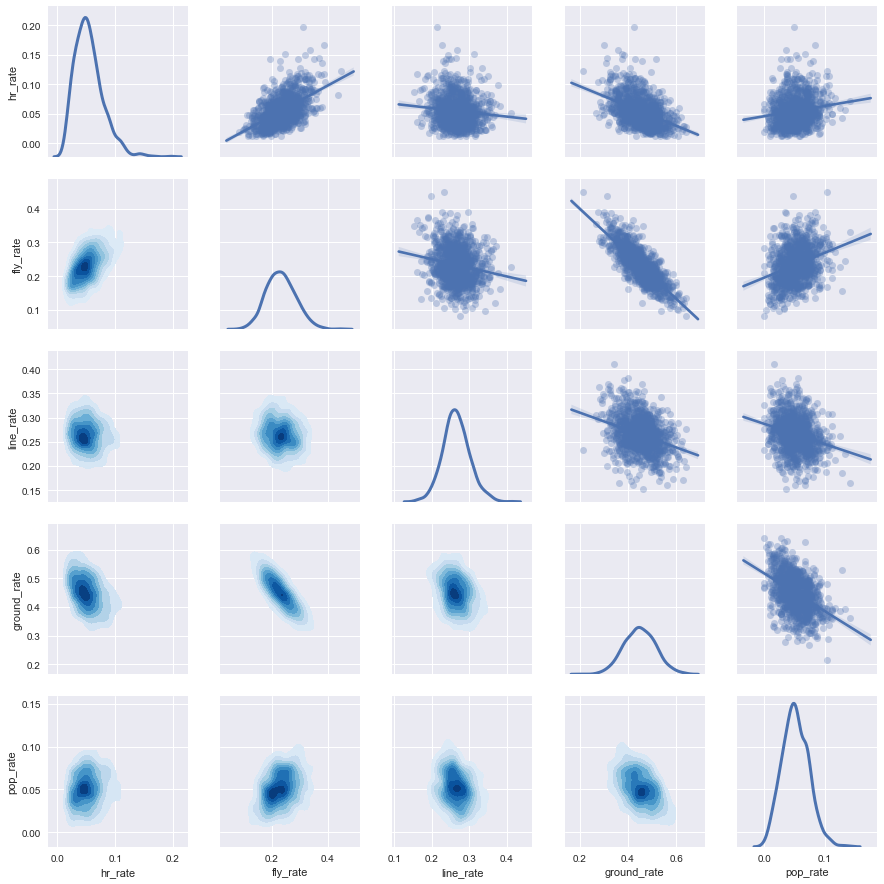

In [11]:
basic_pair_columns = [
    'hr_rate',
    'fly_rate',
    'line_rate',
    'ground_rate',
    'pop_rate'
]
df_basic_pair = df_threshold[basic_pair_columns]

basic_g = sns.PairGrid(df_basic_pair)
basic_g = basic_g.map_upper(sns.regplot, scatter_kws={'alpha': 0.3})
basic_g = basic_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False)
basic_g = basic_g.map_diag(sns.kdeplot, lw=3, legend=False)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


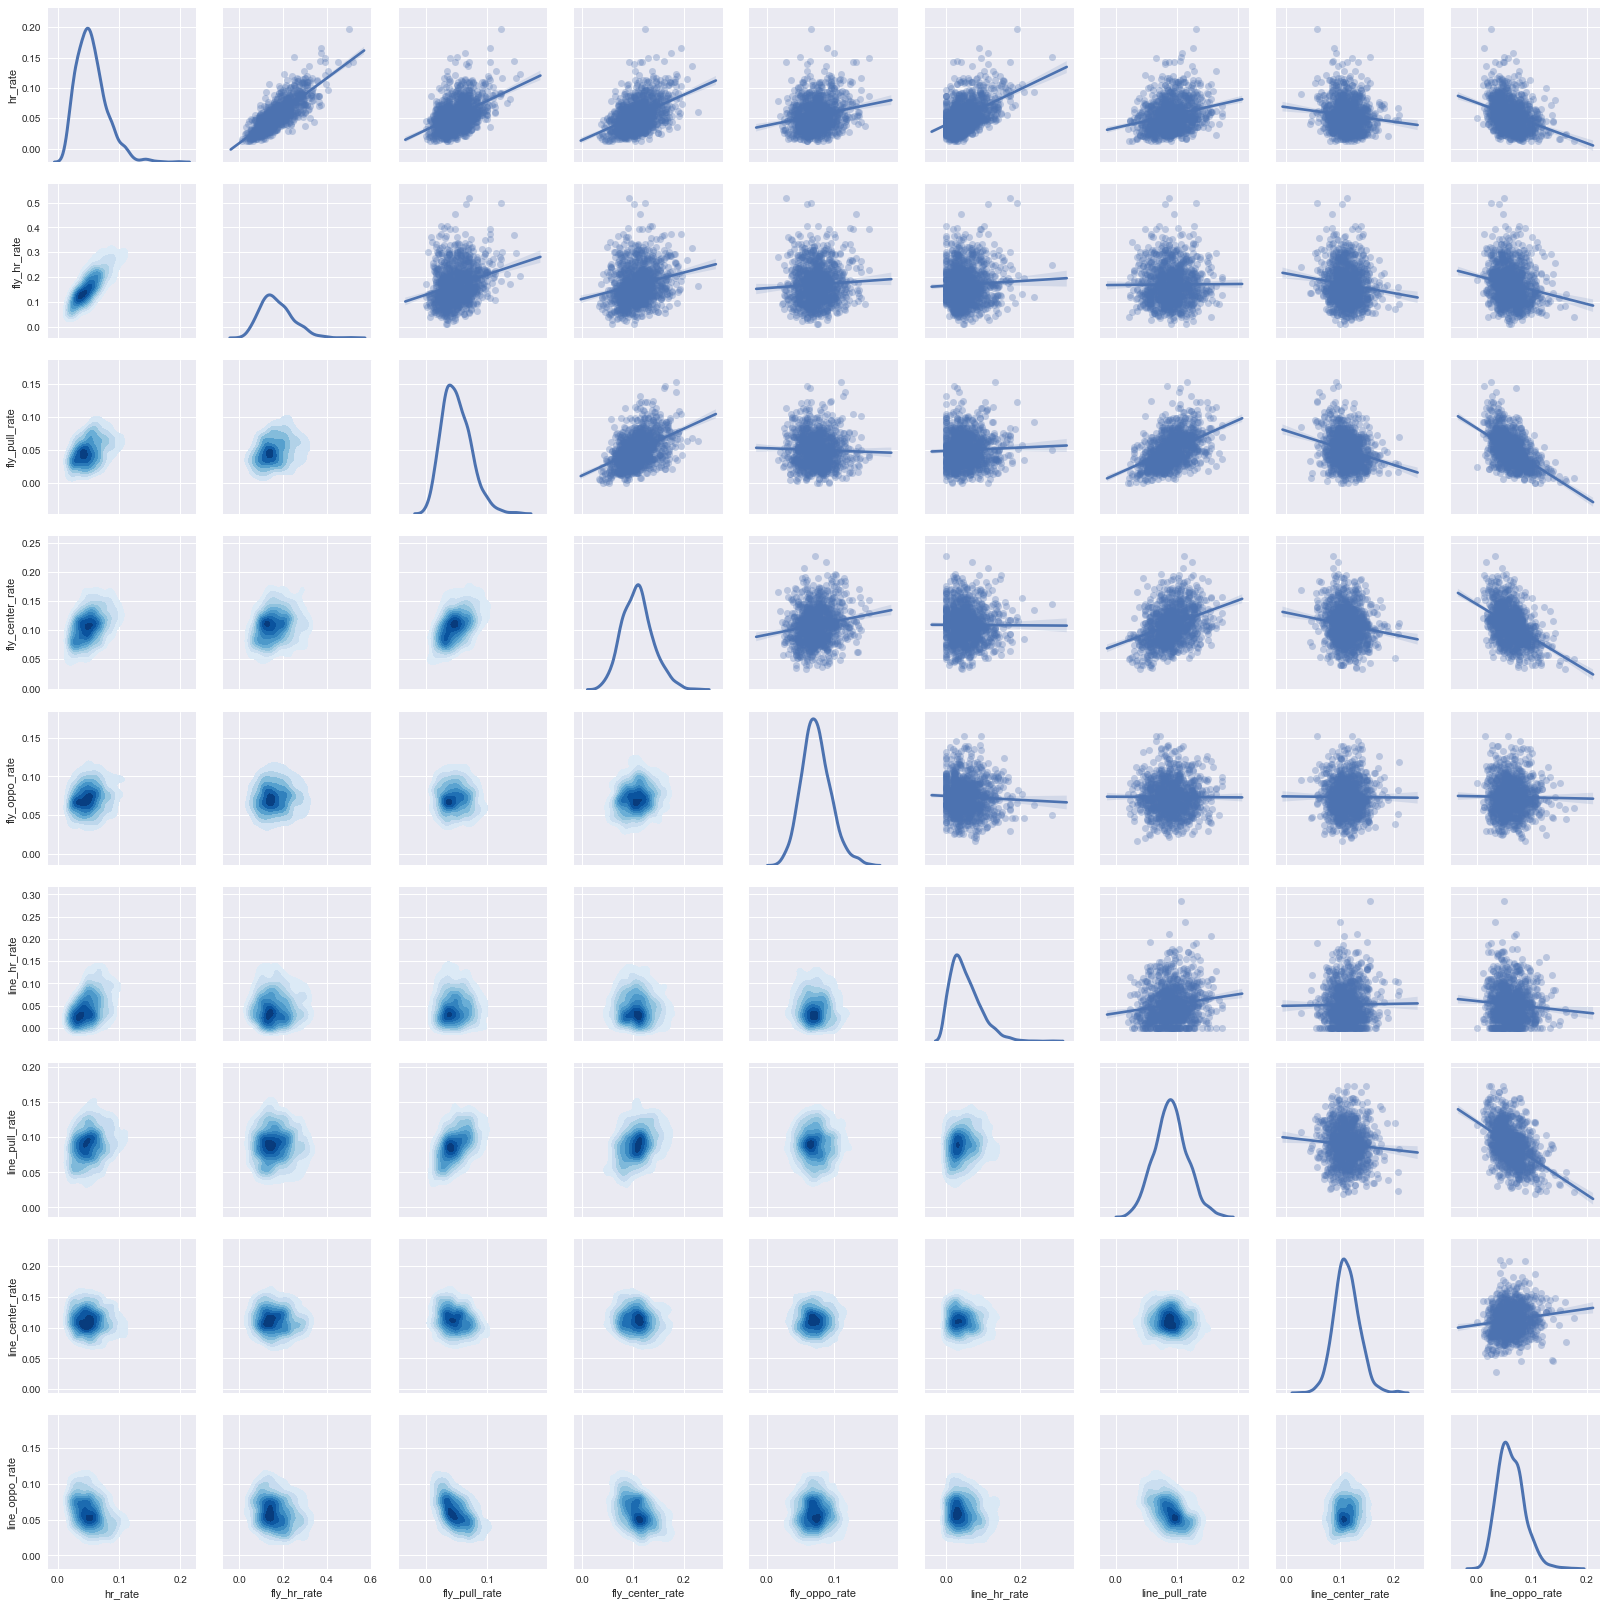

In [12]:
dir_pair_columns = [
    'hr_rate',
    'fly_hr_rate',
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_hr_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate'
]
df_dir_pair = df_threshold[dir_pair_columns]

dir_g = sns.PairGrid(df_dir_pair)
dir_g = dir_g.map_upper(sns.regplot, scatter_kws={'alpha': 0.3})
dir_g = dir_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False)
dir_g = dir_g.map_diag(sns.kdeplot, lw=3, legend=False)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


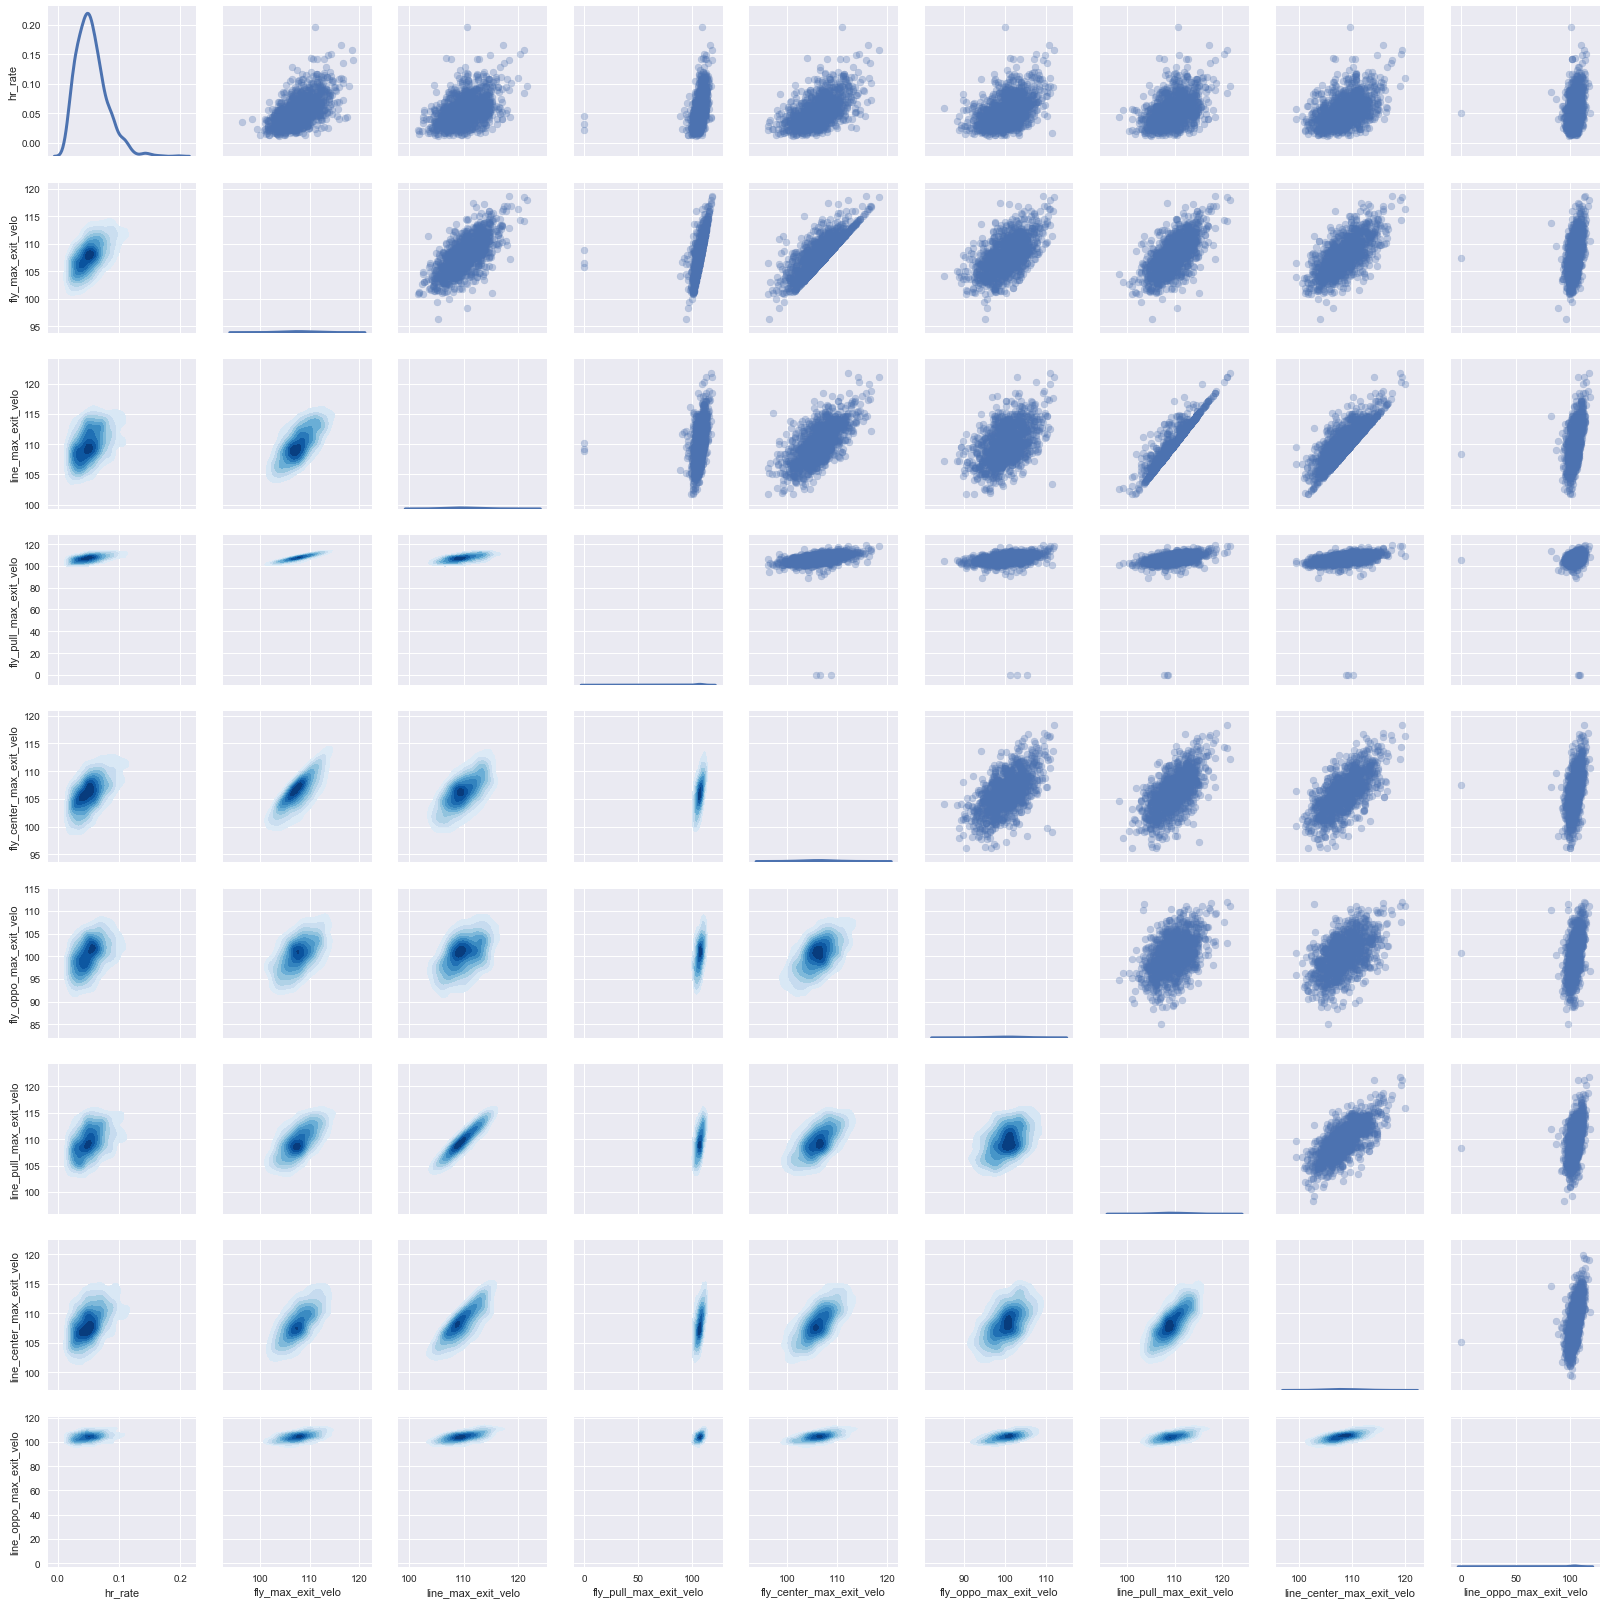

In [13]:
max_velo_pair_columns = [
    'hr_rate',
    'fly_max_exit_velo',
    'line_max_exit_velo',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo'
]
df_max_velo_pair = df_threshold[max_velo_pair_columns]
df_max_velo_pair = df_max_velo_pair.dropna()

max_velo_g = sns.PairGrid(df_max_velo_pair)
max_velo_g = max_velo_g.map_upper(plt.scatter, alpha=0.3)
max_velo_g = max_velo_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False)
max_velo_g = max_velo_g.map_diag(sns.kdeplot, lw=3, legend=False)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


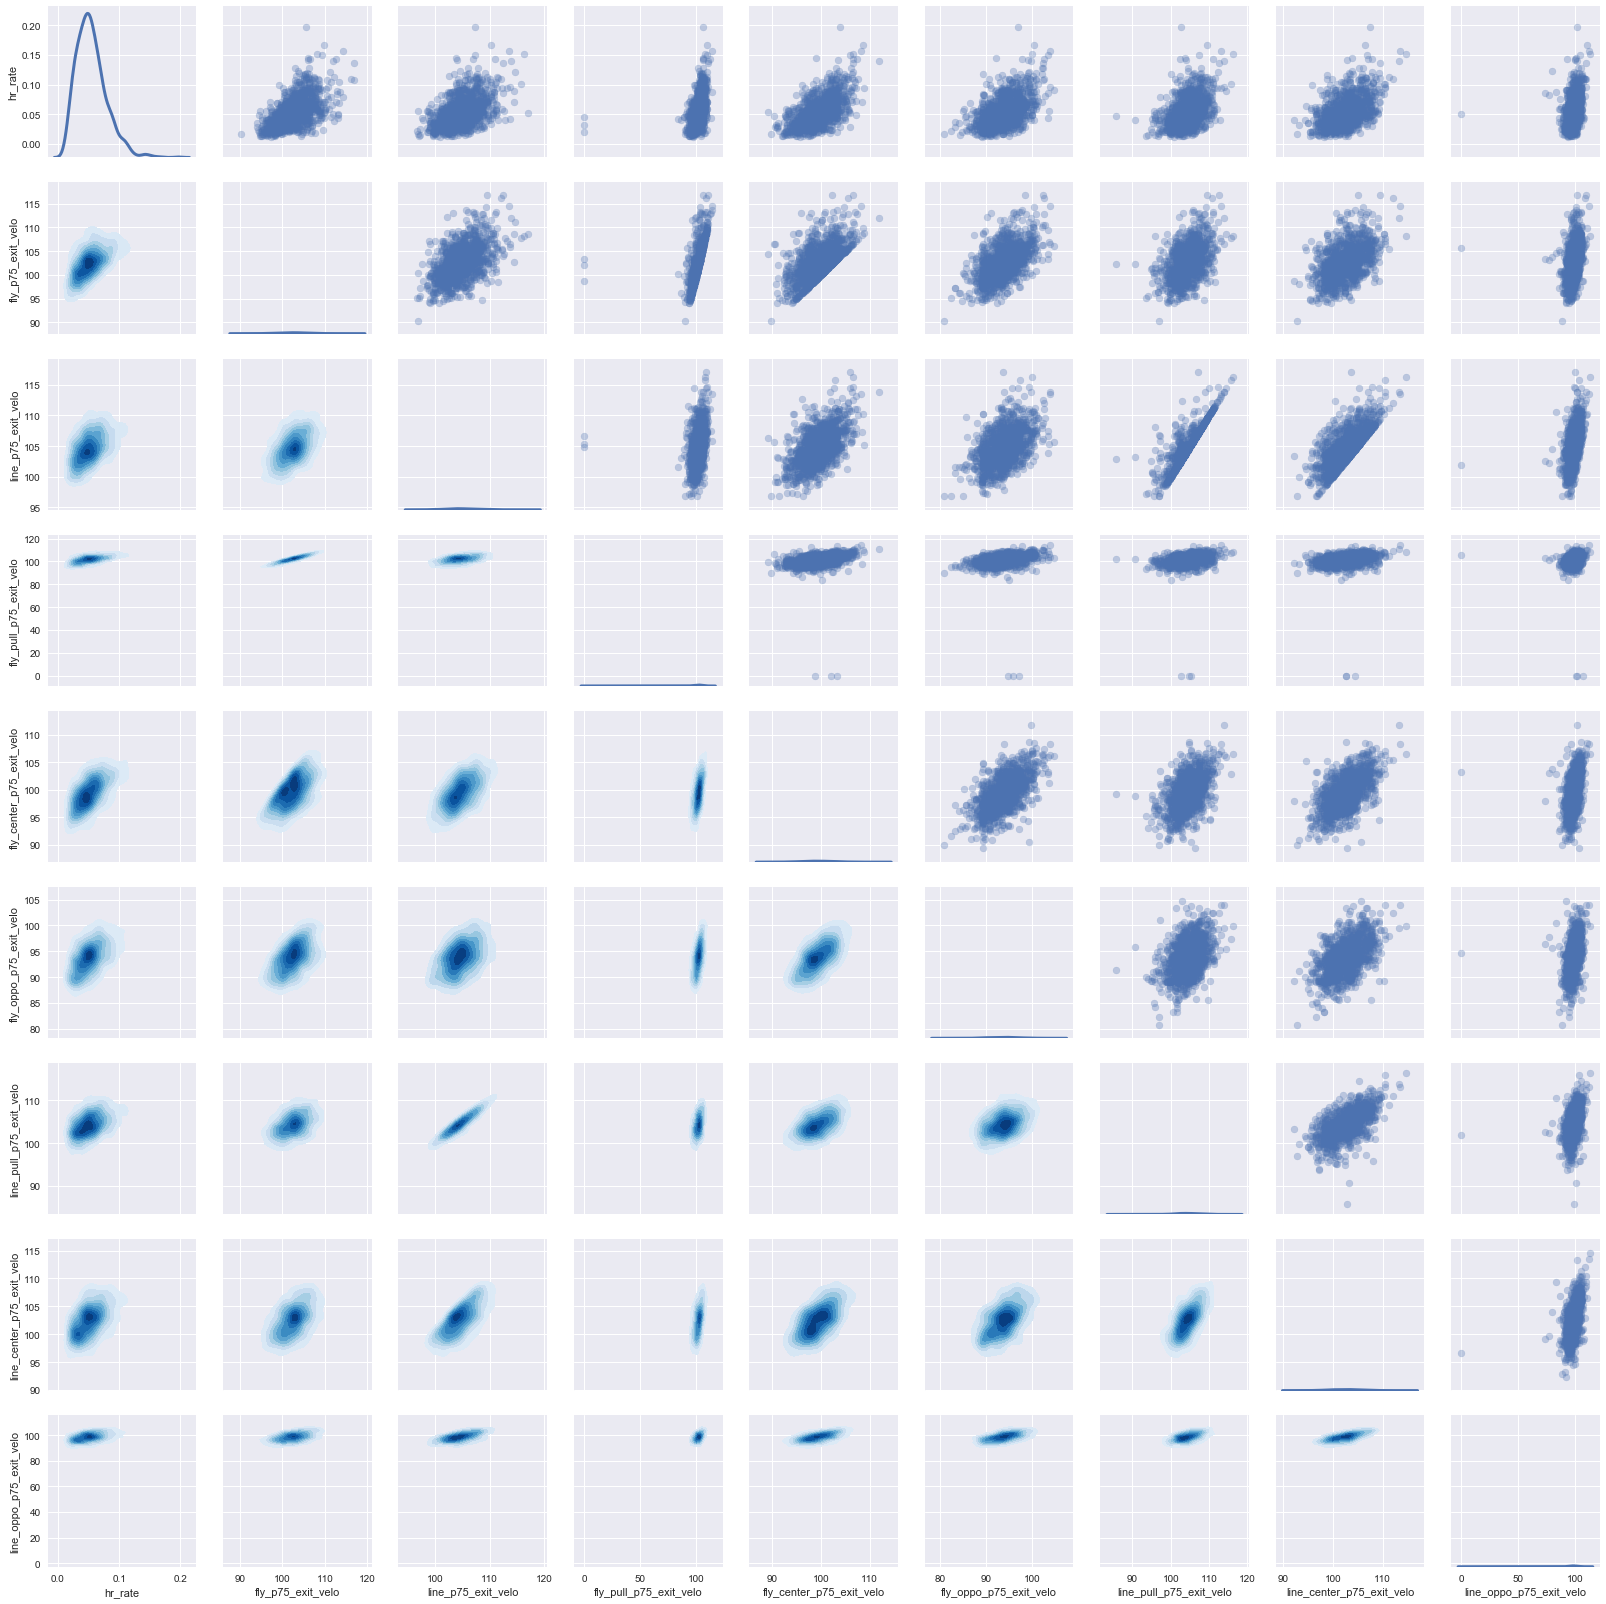

In [14]:
p75_velo_pair_columns = [
    'hr_rate',
    'fly_p75_exit_velo',
    'line_p75_exit_velo',
    'fly_pull_p75_exit_velo',
    'fly_center_p75_exit_velo',
    'fly_oppo_p75_exit_velo',
    'line_pull_p75_exit_velo',
    'line_center_p75_exit_velo',
    'line_oppo_p75_exit_velo'
]
df_p75_velo_pair = df_threshold[p75_velo_pair_columns]
df_p75_velo_pair = df_p75_velo_pair.dropna()

p75_velo_g = sns.PairGrid(df_p75_velo_pair)
p75_velo_g = p75_velo_g.map_upper(plt.scatter, alpha=0.3)
p75_velo_g = p75_velo_g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False)
p75_velo_g = p75_velo_g.map_diag(sns.kdeplot, lw=3, legend=False)

## Modeling
Predicting HR rate based on a variety of inputs

In [15]:
def train_and_evaluate_model(
        df,
        label,
        features,
        model,
        scaler,
        preprocessing=True,
        test_size=0.20
    ):
    
    # Train model
    y = df[label]
    X = df[features]
    
    if preprocessing:
        try:
            X = scaler.fit_transform(X)
        except:
            print("Error:", sys.exc_info()[0])
            raise
        
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    
    # Model description
    if type(model).__name__ in ['LinearRegression', 'ElasticNet', 'LinearSVR']:
        print('MODEL COEFFICIENTS')
        print("{:30}[{:5.3f}]".format('Intercept:', model.intercept_))
        for feature, weight in list(zip(features, model.coef_)):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
            
    elif type(model).__name__ == 'AdaBoostRegressor':
        print('MODEL FEARURE IMPORTANCES')
        for feature, importance in list(zip(features, model.feature_importances_)):
            print("{:30}[{:5.4f}]".format(feature + ":", importance))
        print('\n')
    
    # Model metrics
    evs = explained_variance_score(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    
    print('MODEL METRICS')
    print('Explained Variance Score: {:5.4f}'.format(evs))
    print('Mean Absolute Error: {:5.4f}'.format(mae))
    print('Mean Squared Error: {:5.4f}'.format(mse))
    print('R-Squared: {:5.4f}'.format(r2))
    
    # Residuals plot
    resid_plot = ResidualsPlot(model)
    resid_plot.fit(X_train, y_train)
    resid_plot.score(X_test, y_test)
    resid_plot.poof()
    
    # Prediction error plot
    y_min = np.min(y_test)
    y_max = np.max(y_test)
    y_range = y_max - y_min
    y_limits = (y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    ax = plt.axes()    
    
    pred_plot = PredictionError(model, ax=ax)
    pred_plot.score(X_test, y_test)    
    
    ax.set_xlim(y_limits)
    ax.set_ylim(y_limits)
    
    pred_plot.poof()

### Linear regression (basic features)

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


MODEL COEFFICIENTS
Intercept:                    [0.000]
fly_rate:                     [0.1093]
line_rate:                    [0.0040]
ground_rate:                  [0.0146]
pop_rate:                     [-0.0000]


MODEL METRICS
Explained Variance Score: 0.2546
Mean Absolute Error: 0.0162
Mean Squared Error: 0.0004
R-Squared: 0.2543


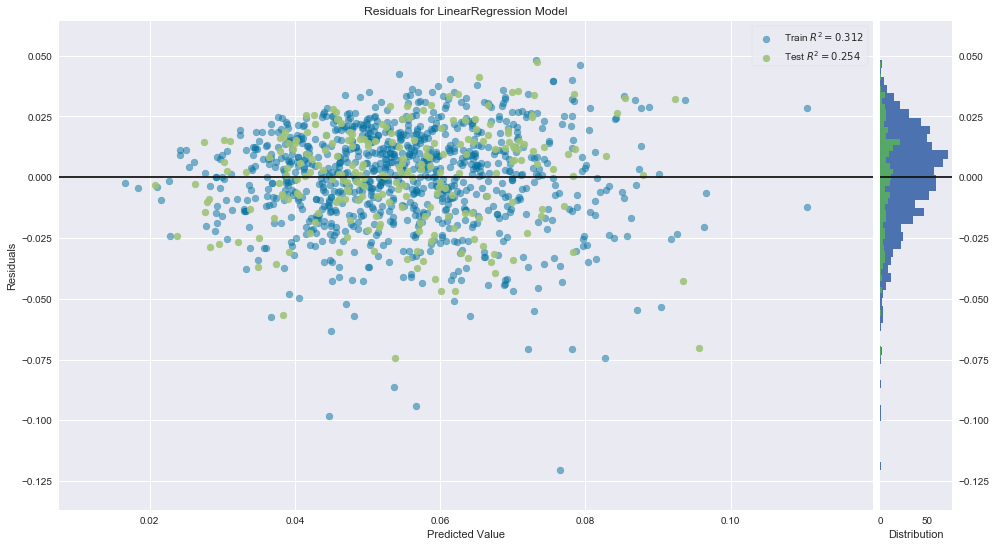

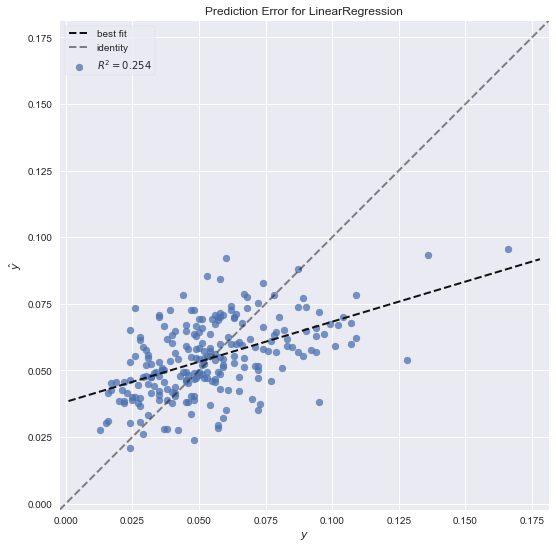

In [16]:
lr_label = 'hr_rate'
lr_features_1 = ['fly_rate', 'line_rate', 'ground_rate', 'pop_rate']

lr_1 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_1 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_1, model=lr_1, scaler=lr_scaler_1)

### Linear regression (directional features)

MODEL COEFFICIENTS
Intercept:                    [0.000]
fly_pull_rate:                [0.0626]
fly_center_rate:              [0.0431]
fly_oppo_rate:                [0.0302]
line_pull_rate:               [-0.0024]
line_center_rate:             [0.0064]
line_oppo_rate:               [-0.0066]
ground_rate:                  [0.0097]


MODEL METRICS
Explained Variance Score: 0.2524
Mean Absolute Error: 0.0162
Mean Squared Error: 0.0004
R-Squared: 0.2521


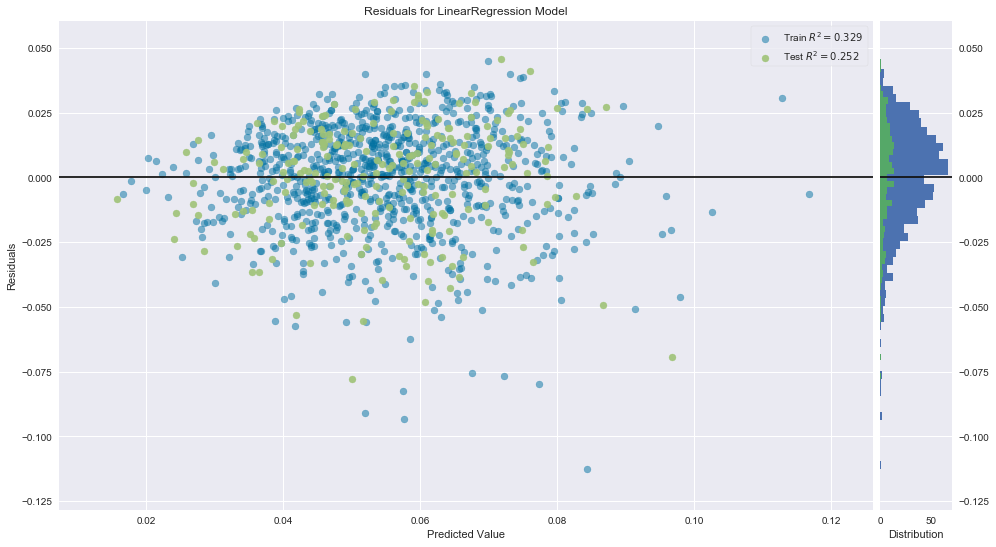

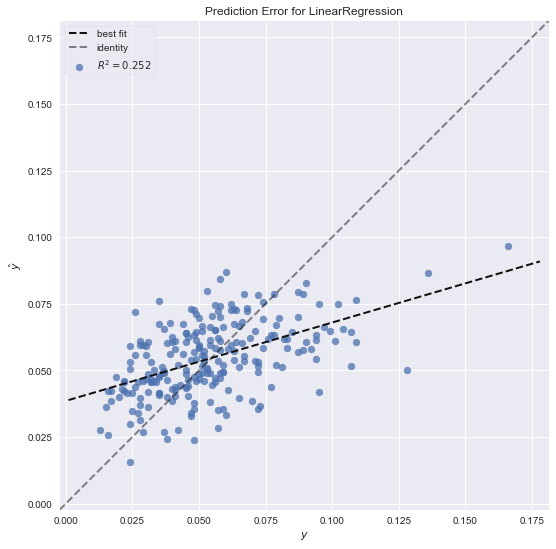

In [17]:
lr_label = 'hr_rate'
lr_features_2 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate'
]

lr_2 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_2 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_2, model=lr_2, scaler=lr_scaler_2)

### Linear regression (basic velocity features)

MODEL COEFFICIENTS
Intercept:                    [0.000]
fly_max_exit_velo:            [0.1022]
line_max_exit_velo:           [0.0372]
ground_max_exit_velo:         [-0.0305]


MODEL METRICS
Explained Variance Score: 0.3552
Mean Absolute Error: 0.0148
Mean Squared Error: 0.0004
R-Squared: 0.3540


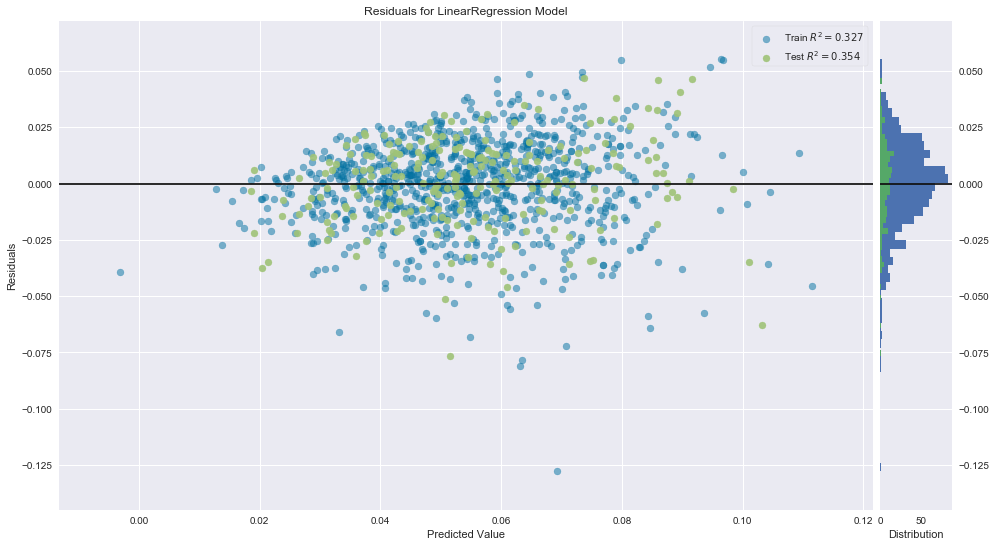

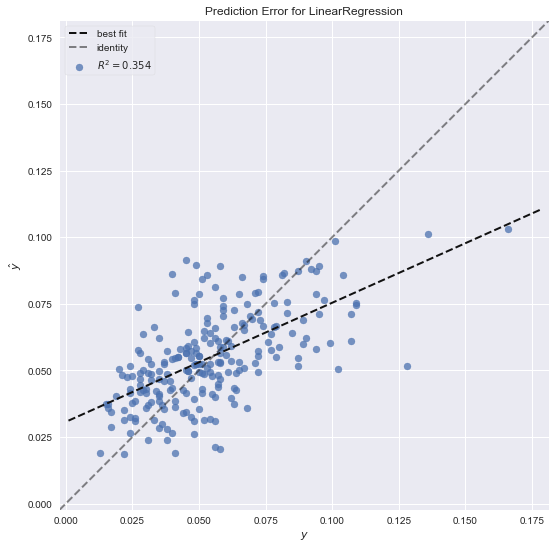

In [18]:
lr_label = 'hr_rate'
lr_features_3 = [
    'fly_max_exit_velo',
    'line_max_exit_velo',
    'ground_max_exit_velo'
]

lr_3 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_3 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_3, model=lr_3, scaler=lr_scaler_3)

### Linear regression (directional velocity features)

MODEL COEFFICIENTS
Intercept:                    [0.000]
fly_pull_max_exit_velo:       [0.0564]
fly_center_max_exit_velo:     [0.0656]
fly_oppo_max_exit_velo:       [0.0275]
line_pull_max_exit_velo:      [0.0248]
line_center_max_exit_velo:    [0.0265]
line_oppo_max_exit_velo:      [-0.0502]
ground_max_exit_velo:         [-0.0433]


MODEL METRICS
Explained Variance Score: 0.3828
Mean Absolute Error: 0.0148
Mean Squared Error: 0.0003
R-Squared: 0.3773


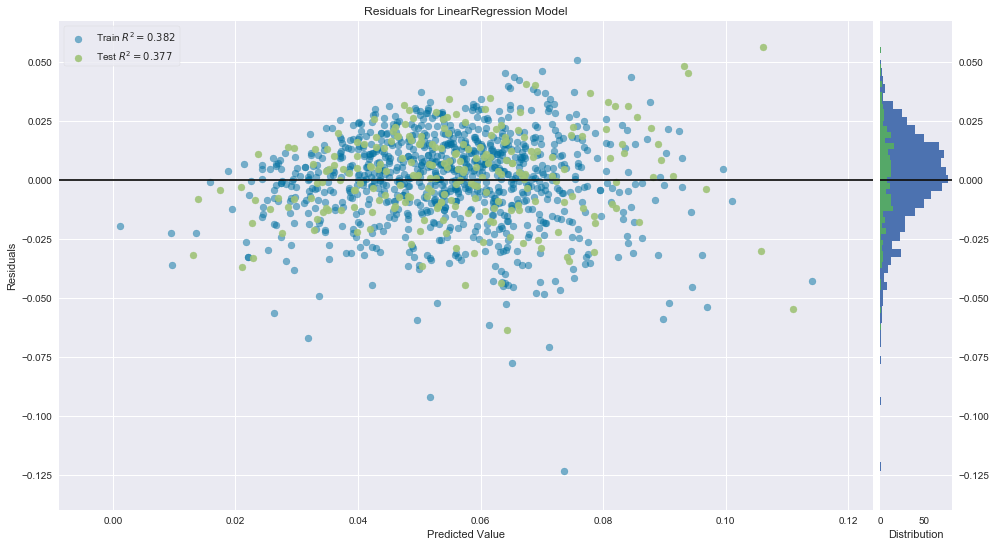

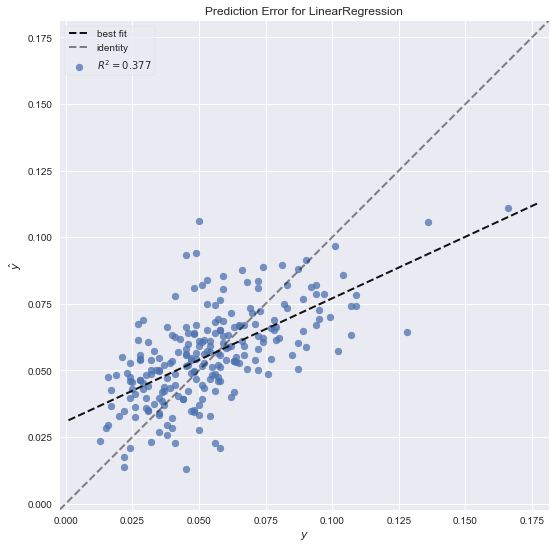

In [19]:
lr_label = 'hr_rate'
lr_features_4 = [
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

lr_4 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_4 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_4, model=lr_4, scaler=lr_scaler_4)

### Linear regression (all features)

MODEL COEFFICIENTS
Intercept:                    [0.000]
fly_pull_rate:                [0.0561]
fly_center_rate:              [-0.0054]
fly_oppo_rate:                [-0.0090]
line_pull_rate:               [-0.0157]
line_center_rate:             [-0.0180]
line_oppo_rate:               [-0.0311]
ground_rate:                  [-0.0568]
pop_rate:                     [-0.0290]
fly_pull_max_exit_velo:       [0.0004]
fly_center_max_exit_velo:     [0.0443]
fly_oppo_max_exit_velo:       [0.0266]
line_pull_max_exit_velo:      [0.0065]
line_center_max_exit_velo:    [0.0289]
line_oppo_max_exit_velo:      [0.0727]
ground_max_exit_velo:         [-0.0101]


MODEL METRICS
Explained Variance Score: 0.5874
Mean Absolute Error: 0.0117
Mean Squared Error: 0.0002
R-Squared: 0.5863


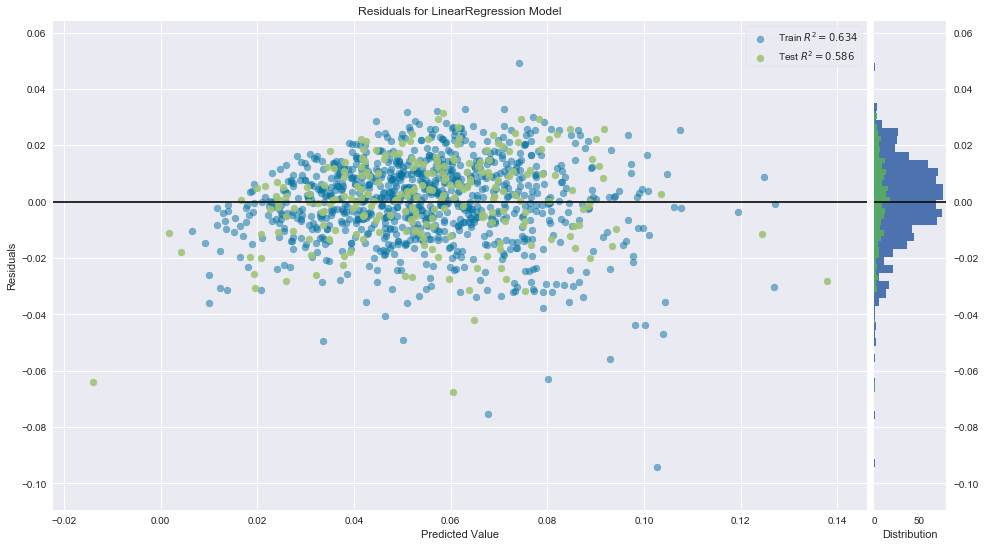

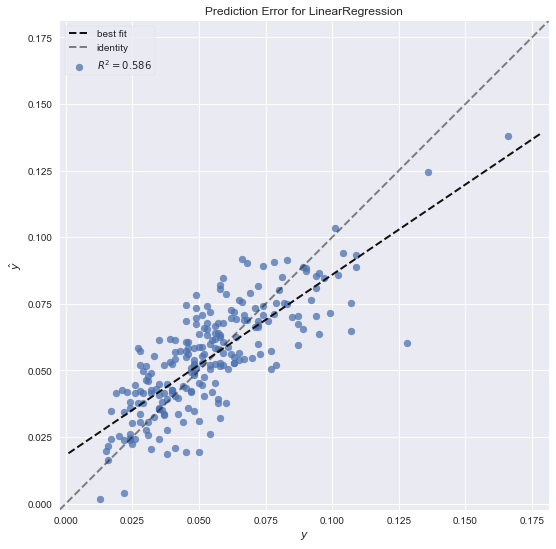

In [20]:
lr_label = 'hr_rate'
lr_features_5 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

lr_5 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_5 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_5, model=lr_5, scaler=lr_scaler_5)

### Linear Regression (all features using 95th percentile velocities)

MODEL COEFFICIENTS
Intercept:                    [0.000]
fly_pull_rate:                [0.0558]
fly_center_rate:              [-0.0031]
fly_oppo_rate:                [-0.0078]
line_pull_rate:               [-0.0139]
line_center_rate:             [-0.0119]
line_oppo_rate:               [-0.0277]
ground_rate:                  [-0.0577]
pop_rate:                     [-0.0277]
fly_pull_p95_exit_velo:       [0.0032]
fly_center_p95_exit_velo:     [0.0469]
fly_oppo_p95_exit_velo:       [0.0255]
line_pull_p95_exit_velo:      [0.0001]
line_center_p95_exit_velo:    [0.0296]
line_oppo_p95_exit_velo:      [0.0614]
ground_p95_exit_velo:         [0.0026]


MODEL METRICS
Explained Variance Score: 0.6481
Mean Absolute Error: 0.0110
Mean Squared Error: 0.0002
R-Squared: 0.6476


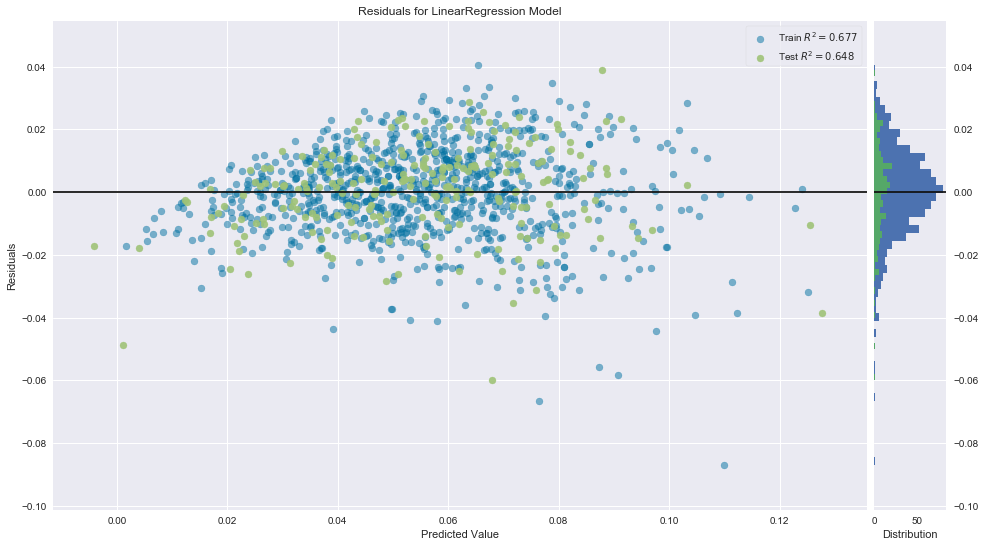

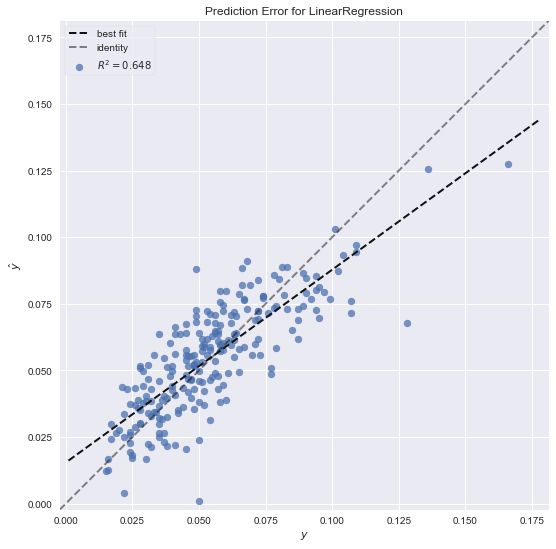

In [28]:
lr_label = 'hr_rate'
lr_features_6 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_p95_exit_velo',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_pull_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo',
    'ground_p95_exit_velo'
]

lr_6 = LinearRegression(fit_intercept=False, copy_X=True)
lr_scaler_6 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lr_label, features=lr_features_6, model=lr_6, scaler=lr_scaler_6)

### Elastic Net Regression (all features)

MODEL COEFFICIENTS
Intercept:                    [0.055]
fly_pull_rate:                [0.0103]
fly_center_rate:              [0.0024]
fly_oppo_rate:                [0.0007]
line_pull_rate:               [0.0000]
line_center_rate:             [0.0000]
line_oppo_rate:               [-0.0010]
ground_rate:                  [-0.0017]
pop_rate:                     [-0.0011]
fly_pull_max_exit_velo:       [0.0000]
fly_center_max_exit_velo:     [0.0068]
fly_oppo_max_exit_velo:       [0.0042]
line_pull_max_exit_velo:      [0.0003]
line_center_max_exit_velo:    [0.0039]
line_oppo_max_exit_velo:      [0.0019]
ground_max_exit_velo:         [-0.0000]


MODEL METRICS
Explained Variance Score: 0.6163
Mean Absolute Error: 0.0114
Mean Squared Error: 0.0002
R-Squared: 0.6154


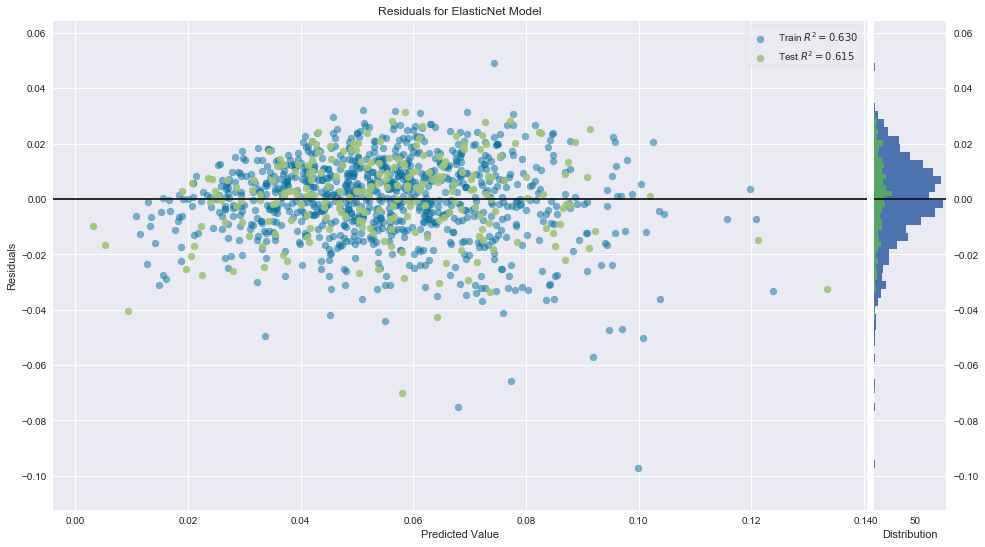

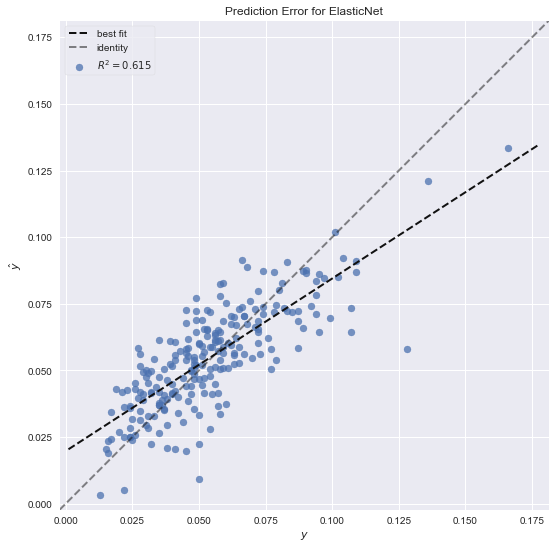

In [21]:
en_label = 'hr_rate'
en_features_1 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

en_1 = ElasticNet(alpha=0.01, l1_ratio=0.05, fit_intercept=True, copy_X=True)
en_scaler_1 = StandardScaler()

train_and_evaluate_model(df=df_threshold, label=en_label, features=en_features_1, model=en_1, scaler=en_scaler_1)

### Elastic Net Regression (all features using 95th percentile velocities)

MODEL COEFFICIENTS
Intercept:                    [0.055]
fly_pull_rate:                [0.0096]
fly_center_rate:              [0.0021]
fly_oppo_rate:                [0.0004]
line_pull_rate:               [0.0000]
line_center_rate:             [0.0000]
line_oppo_rate:               [-0.0011]
ground_rate:                  [-0.0029]
pop_rate:                     [-0.0012]
fly_pull_p95_exit_velo:       [0.0001]
fly_center_p95_exit_velo:     [0.0073]
fly_oppo_p95_exit_velo:       [0.0039]
line_pull_p95_exit_velo:      [0.0000]
line_center_p95_exit_velo:    [0.0046]
line_oppo_p95_exit_velo:      [0.0020]
ground_p95_exit_velo:         [0.0000]


MODEL METRICS
Explained Variance Score: 0.6609
Mean Absolute Error: 0.0108
Mean Squared Error: 0.0002
R-Squared: 0.6605


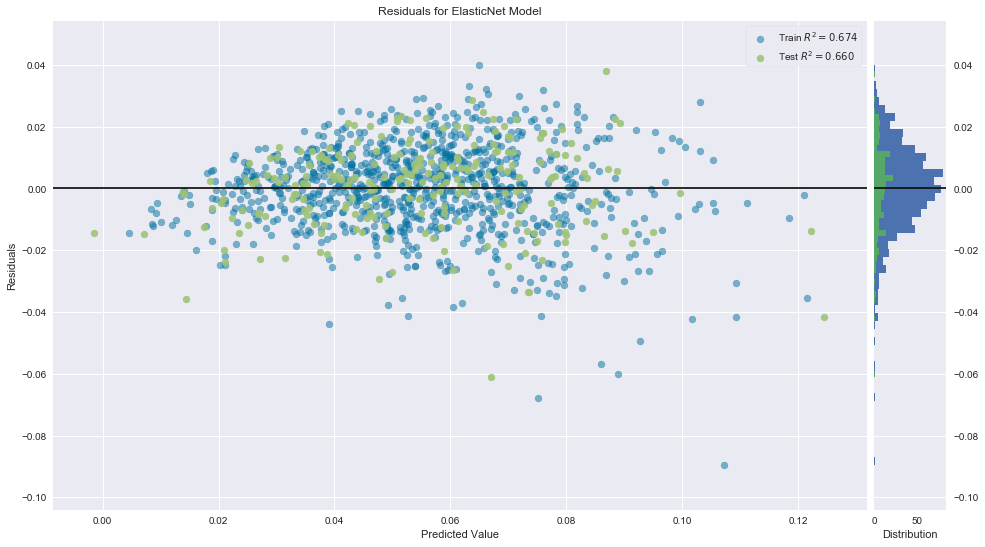

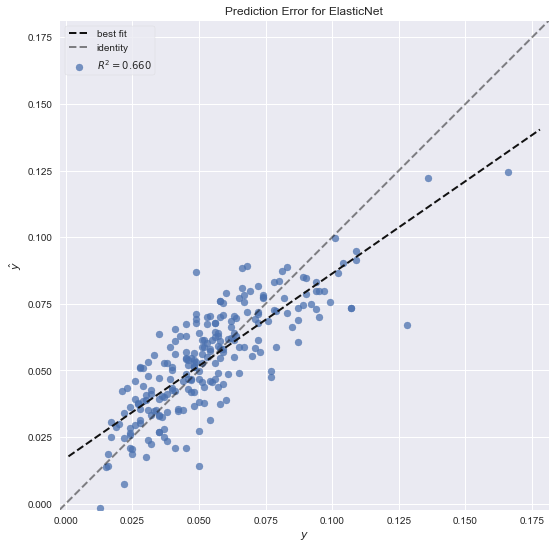

In [27]:
en_label = 'hr_rate'
en_features_2 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_p95_exit_velo',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_pull_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo',
    'ground_p95_exit_velo'
]

en_2 = ElasticNet(alpha=0.01, l1_ratio=0.05, fit_intercept=True, copy_X=True)
en_scaler_2 = StandardScaler()

train_and_evaluate_model(df=df_threshold, label=en_label, features=en_features_2, model=en_2, scaler=en_scaler_2)

### Ada Boost Regression (all features)

MODEL FEARURE IMPORTANCES
fly_pull_rate:                [0.2913]
fly_center_rate:              [0.0298]
fly_oppo_rate:                [0.0292]
line_pull_rate:               [0.0210]
line_center_rate:             [0.0345]
line_oppo_rate:               [0.0175]
ground_rate:                  [0.0285]
pop_rate:                     [0.0329]
fly_pull_max_exit_velo:       [0.0927]
fly_center_max_exit_velo:     [0.2457]
fly_oppo_max_exit_velo:       [0.0964]
line_pull_max_exit_velo:      [0.0064]
line_center_max_exit_velo:    [0.0416]
line_oppo_max_exit_velo:      [0.0303]
ground_max_exit_velo:         [0.0022]


MODEL METRICS
Explained Variance Score: 0.5543
Mean Absolute Error: 0.0130
Mean Squared Error: 0.0003
R-Squared: 0.5168


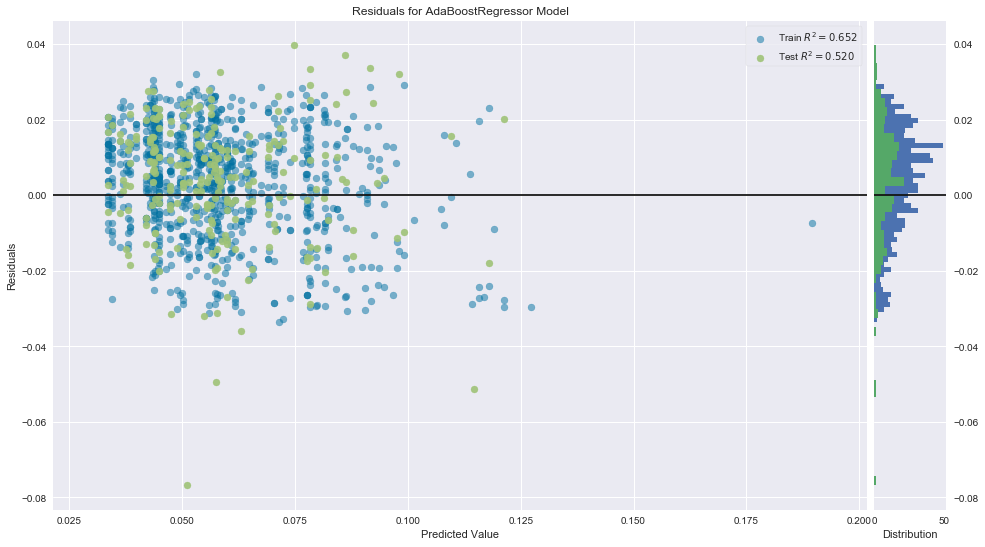

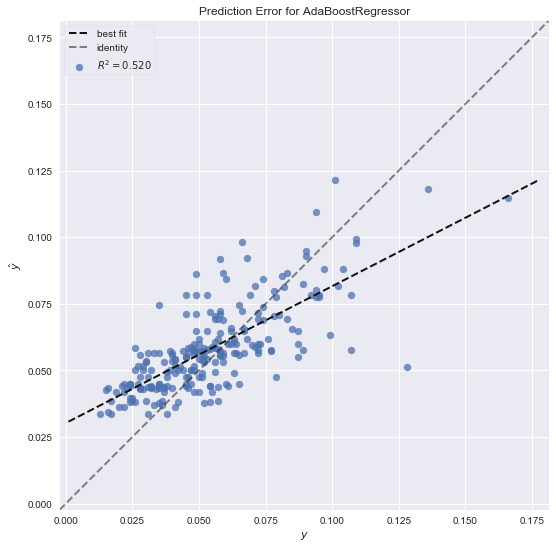

In [22]:
ab_label = 'hr_rate'
ab_features_1 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

ab_1 = AdaBoostRegressor(n_estimators=50, loss='linear')
ab_scaler_1 = StandardScaler()

train_and_evaluate_model(df=df_threshold, label=ab_label, features=ab_features_1, model=ab_1, scaler=ab_scaler_1)

### Linear SVR Regression (all features)

MODEL COEFFICIENTS
Intercept:                    [0.000]
fly_pull_rate:                [0.0533]
fly_center_rate:              [-0.0087]
fly_oppo_rate:                [-0.0099]
line_pull_rate:               [-0.0162]
line_center_rate:             [-0.0136]
line_oppo_rate:               [-0.0332]
ground_rate:                  [-0.0551]
pop_rate:                     [-0.0278]
fly_pull_max_exit_velo:       [0.0030]
fly_center_max_exit_velo:     [0.0379]
fly_oppo_max_exit_velo:       [0.0268]
line_pull_max_exit_velo:      [0.0219]
line_center_max_exit_velo:    [0.0250]
line_oppo_max_exit_velo:      [0.0713]
ground_max_exit_velo:         [-0.0158]


MODEL METRICS
Explained Variance Score: 0.5872
Mean Absolute Error: 0.0119
Mean Squared Error: 0.0002
R-Squared: 0.5809


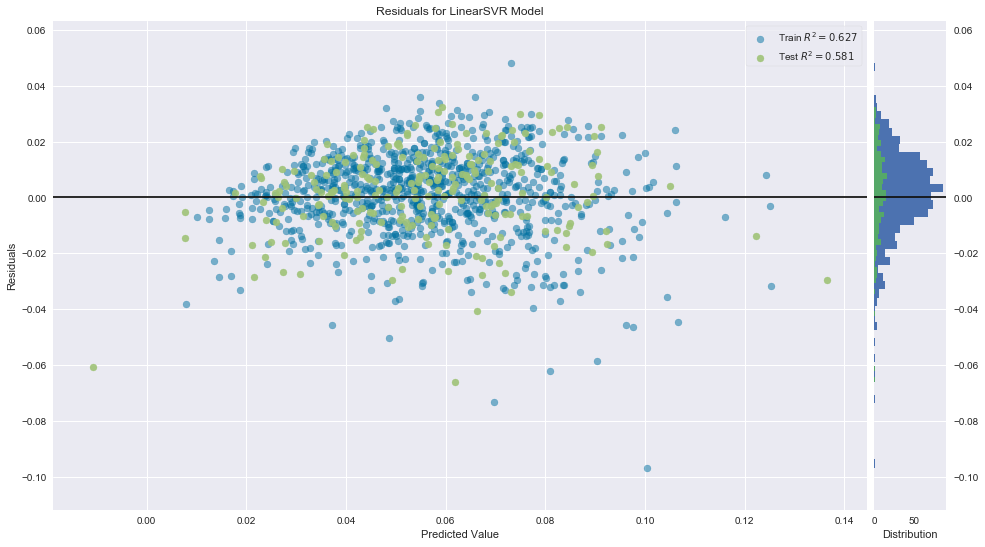

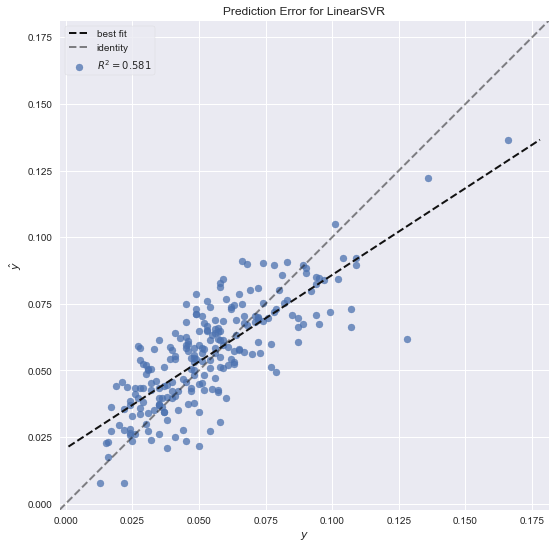

In [23]:
lsv_label = 'hr_rate'
lsv_features_1 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

lsv_1 = LinearSVR(C=1.0, fit_intercept=False, random_state=42)
lsv_scaler_1 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=lsv_label, features=lsv_features_1, model=lsv_1, scaler=lsv_scaler_1)

### RBF SVR Regression (all features)

MODEL METRICS
Explained Variance Score: 0.6128
Mean Absolute Error: 0.0112
Mean Squared Error: 0.0002
R-Squared: 0.6098


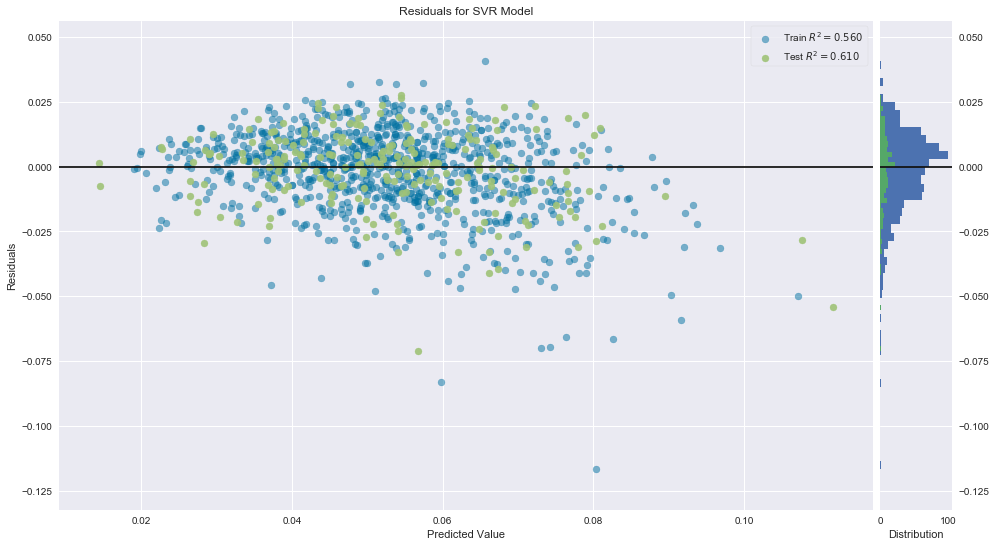

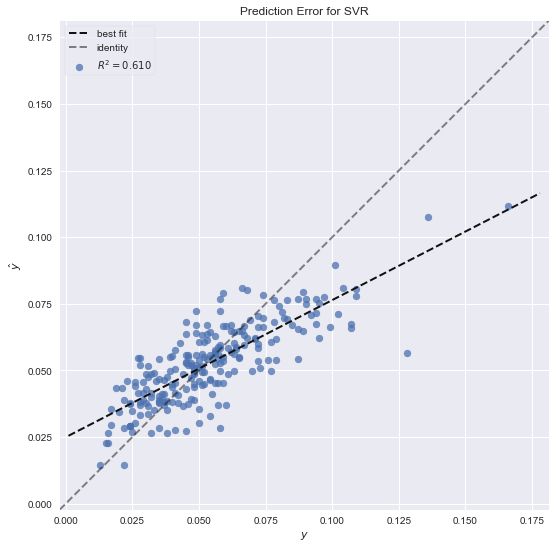

In [24]:
svr_label = 'hr_rate'
svr_features_1 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_max_exit_velo',
    'fly_center_max_exit_velo',
    'fly_oppo_max_exit_velo',
    'line_pull_max_exit_velo',
    'line_center_max_exit_velo',
    'line_oppo_max_exit_velo',
    'ground_max_exit_velo'
]

svr_1 = SVR(kernel='rbf', C=0.01, epsilon=0.005)
svr_scaler_1 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=svr_label, features=svr_features_1, model=svr_1, scaler=svr_scaler_1)

### RBF SVR Regression (all features using 95th percentile velocities)

MODEL METRICS
Explained Variance Score: 0.6550
Mean Absolute Error: 0.0104
Mean Squared Error: 0.0002
R-Squared: 0.6528


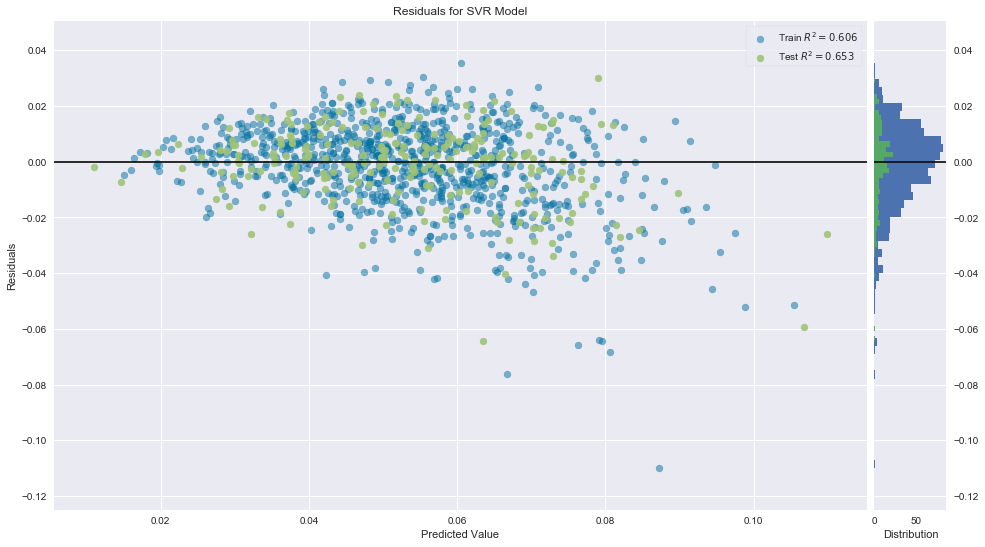

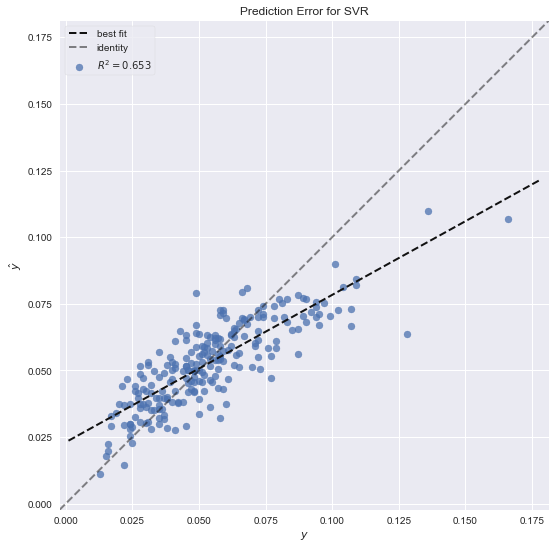

In [25]:
svr_label = 'hr_rate'
svr_features_2 = [
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate',
    'ground_rate',
    'pop_rate',
    'fly_pull_p95_exit_velo',
    'fly_center_p95_exit_velo',
    'fly_oppo_p95_exit_velo',
    'line_pull_p95_exit_velo',
    'line_center_p95_exit_velo',
    'line_oppo_p95_exit_velo',
    'ground_p95_exit_velo'
]

svr_2 = SVR(kernel='rbf', C=0.01, epsilon=0.005)
svr_scaler_2 = MinMaxScaler()

train_and_evaluate_model(df=df_threshold, label=svr_label, features=svr_features_2, model=svr_2, scaler=svr_scaler_2)